## Diffusion coefficient and alpha variation with time by running window analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sns
import matplotlib.cm as cm
from scipy import stats

In [2]:
# Load the CSV file
file_path = r'Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\no_drug\Analysed Data\2x\Trackmate analysis new 07052024\flagged_tracks_w20\20240118_UGD-2x-2s-replicate1-FOV-2-wstepflags.csv' 
data = pd.read_csv(file_path)

In [3]:
# Ensure step_flag is boolean and filter for True values
data['step_flag'] = data['step_flag'].astype(str).str.upper() == 'TRUE'

In [4]:
def has_consecutive_true(df, col='step_flag'):
    return df[col].rolling(window=2).apply(lambda x: all(x), raw=True).any()

valid_track_ids = data.groupby('trackID').filter(has_consecutive_true)['trackID'].unique()
if len(valid_track_ids) == 0:
    raise ValueError("No trackIDs found with consecutive TRUE values in step_flag.")

In [5]:
track_id = 195

In [6]:
# track_id = np.random.choice(valid_track_ids, 1)[0]
track_data = data[data['trackID'] == track_id].copy()

In [7]:
um_per_pixel = 0.117
track_data['x'] = track_data['x'] * um_per_pixel
track_data['y'] = track_data['y'] * um_per_pixel

In [8]:
s_per_frame = 2
track_data['t'] = track_data['t'] * s_per_frame

In [9]:
# Store results for future access and extract values
stored_track_data = track_data.copy()
stored_random_track_id = track_id
x = track_data['x'].values
y = track_data['y'].values
t = track_data['t'].values

# Debugging: Print x, y, t values
print("Debug information:")
print("Stored Track Data:")
print(stored_track_data)

Debug information:
Stored Track Data:
       trackID          x          y      t  R2  alpha   D  step_sizes  \
32151      195  35.795500  57.641286    0.0 NaN    NaN NaN         NaN   
32152      195  35.810790  57.643472    2.0 NaN    NaN NaN    0.132018   
32153      195  35.748289  57.626420    4.0 NaN    NaN NaN    0.553720   
32154      195  35.779825  57.588105    6.0 NaN    NaN NaN    0.424137   
32155      195  35.765743  57.622542    8.0 NaN    NaN NaN    0.317994   
...        ...        ...        ...    ...  ..    ...  ..         ...   
32346      195  35.066147  58.980443  390.0 NaN    NaN NaN    0.235306   
32347      195  35.043979  59.036088  392.0 NaN    NaN NaN    0.511944   
32348      195  35.133603  58.987121  394.0 NaN    NaN NaN    0.872894   
32349      195  35.192316  58.998522  396.0 NaN    NaN NaN    0.511196   
32350      195  35.118890  58.968847  398.0 NaN    NaN NaN    0.676886   

       mean_step_sizes      x_mean      y_mean cellID  step_flag  
32151 

x_plot: [ 0.4616084   0.47689894  0.41439821  0.44593362  0.43185214  0.41558164
  0.3590464   0.3236465   0.32054197  0.32933356  0.29986493  0.32467625
  0.27481642  0.30631151  0.28951638  0.29152977  0.31480902  0.30925238
  0.28265673  0.30382969  0.34489401  0.32580336  0.30919077  0.34670388
  0.33898852  0.31522696  0.34362661  0.32106883  0.29099388  0.30014734
  0.30095705  0.30530015  0.29224565  0.26886478  0.26001974  0.17839287
  0.20002998  0.17181511  0.13045355  0.13944681  0.15463701  0.17591318
  0.19732491  0.11746769  0.15062427  0.14333176  0.17624218  0.18589371
  0.24727969  0.21632976  0.2456313   0.26075516  0.27335231  0.29798514
  0.31079587  0.27780463  0.27367373  0.25297684  0.25992257  0.23036423
  0.23419359  0.23787011  0.24517433  0.26882592  0.2403292   0.2349906
  0.27532406  0.29641649  0.25658491  0.24605144  0.27226769  0.2979295
  0.30893119  0.26639484  0.2831583   0.26803616  0.2865633   0.26921287
  0.29443662  0.29633761  0.29113795  0.29032

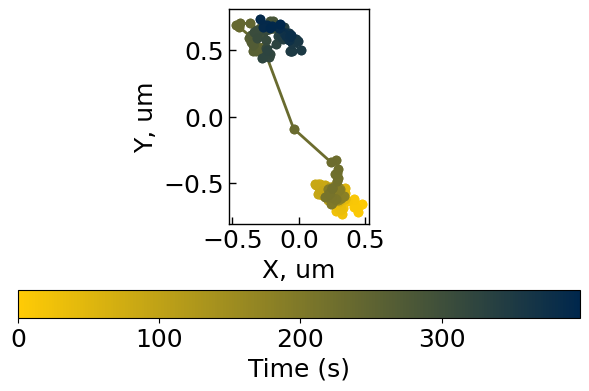

In [10]:
cmap_color_start = "#FFCB05"
cmap_color_end = "#00274C"
cmap_name = "maize2blue"
cmap = clr.LinearSegmentedColormap.from_list(cmap_name, [cmap_color_start, cmap_color_end], N=len(t))
fontsize = 18
x_plot = x - (x.min() + x.max()) / 2
y_plot = y - (y.min() + y.max()) / 2

print(f"x_plot: {x_plot}")
print(f"y_plot: {y_plot}")

fig, ax = plt.subplots(figsize=(6, 4))

# Plot the trajectory with color mapping
for i in range(len(t) - 1):
    ax.plot(
        x_plot[i:i + 2], y_plot[i:i + 2], "-o",
        color=cmap(i / len(t)),
        linewidth=2
    )

# Customize plot aesthetics
ax.axis("scaled")
ax.spines[:].set_linewidth(1)
ax.tick_params(
    axis="both",
    which="major",
    labelsize=fontsize,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1
)
ax.set_xlabel('X, um', fontsize=18)
ax.set_ylabel('Y, um', fontsize=18)

ax.relim()
ax.autoscale_view()

normalize = clr.Normalize(vmin=t.min(), vmax=t.max())
cbar = plt.colorbar(
    cm.ScalarMappable(norm=normalize, cmap=cmap),
    ax=ax,
    orientation='horizontal',
    pad=0.2,
    drawedges=False
)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label('Time (s)', fontsize=18)
# Final layout adjustments and show the plot
plt.tight_layout()
plt.show()

In [11]:
# Define the MSD calculation function
def calc_MSD_NonPhysUnit(df_track, lags):
    df_track_sorted = df_track.sort_values("t")
    # Prepare storage arrays
    MSDs = []

    # Calculate MSDs corresponding to a series of lag times
    for lag in lags:
        Xs = np.array(df_track_sorted .x, dtype=float)
        Ys = np.array(df_track_sorted .y, dtype=float)

        SquareDisplacements = (Xs[lag:] - Xs[:-lag]) ** 2 + (Ys[lag:] - Ys[:-lag]) ** 2
        MSD = np.nanmean(SquareDisplacements)
        MSDs.append(MSD)

    MSDs = np.array(MSDs, dtype=float)
    return MSDs

In [12]:
# Running window analysis
window_size = 20
lags = np.linspace(1, window_size, window_size).astype(int)
lst_t_start = []
lst_log10D = []
lst_alpha = []
lst_step_size = []
# Set a minimal for how many datapoints needed to calculate the last MSD value (of the largest lag)
minimal_datapoints = 5

df_track = stored_track_data.copy()  # Use stored data for window analysis

for i in range(df_track.shape[0] - lags.shape[0] - minimal_datapoints):
    MSDs = calc_MSD_NonPhysUnit(
        df_track.iloc[i: i + lags.shape[0] + minimal_datapoints], lags
    )
    if np.isnan(MSDs).any():
        print(i)
    lags_phys = lags 
    MSDs_phys = MSDs 
    # slope_linear, intercept_linear, R_linear, P, std_err = stats.linregress(
    #     lags_phys, MSDs_phys
    # )
    # D_phys_linear = slope_linear / (8 / 3)  # um^2/s
    slope_loglog, intercept_loglog, R_loglog, P, std_err = stats.linregress(
        np.log10(lags_phys),
        np.log10(MSDs_phys),
    )
    D_loglog = (10**intercept_loglog) / (4)
    alpha = slope_loglog

    lst_t_start.append(df_track.iloc[i:i + lags.shape[0]]["t"].mean())
    lst_log10D.append(D_loglog)
    lst_alpha.append(alpha)

    # Calculate mean step sizes for each segment
    segment = df_track.iloc[i:i+lags.shape[0]]
    x_diffs = np.diff(segment['x'])
    y_diffs = np.diff(segment['y'])
    step_sizes = np.sqrt(x_diffs**2 + y_diffs**2)
    mean_step_size = np.mean(step_sizes)
    lst_step_size.append(mean_step_size)

arr_t_start = np.array(lst_t_start, dtype=float)
arr_t_start = arr_t_start - arr_t_start[0]
arr_log10D = np.array(lst_log10D, dtype=float)
arr_alpha = np.array(lst_alpha, dtype=float)
arr_step_size = np.array(lst_step_size, dtype=float)

In [13]:
# Print lists of alpha, diffusion coefficient, and step sizes
print("List of alpha values:")
print(lst_alpha)
print("\nList of diffusion coefficients (D_loglog):")
print(lst_log10D)
print("\nList of step sizes:")
print(lst_step_size)

List of alpha values:
[0.8721798398821169, 0.8514463185279029, 0.8588207395125306, 0.8704422446790676, 0.7873157610139578, 0.7358443558273817, 0.759826247526127, 0.8351341470209825, 0.8171938808788781, 0.7909609409565171, 0.7970244251027543, 0.8020339888631842, 0.7825229940260771, 0.7862091654019333, 0.8282283829657915, 0.8928922577743554, 0.9421458989582271, 0.9650383820123617, 0.978035257930301, 1.0369617761314194, 1.0609068710219602, 1.0402884232532885, 1.0312041440631694, 1.0136636054141117, 0.8951708069745581, 0.8043334625849363, 0.7270576198519834, 0.5966640138465676, 0.4665412194584352, 0.4184850888755519, 0.4545072386836519, 0.5199072144183109, 0.5655332652080712, 0.6347594385895261, 0.7442488540297496, 0.8070609087895115, 0.7776121593168436, 0.8011834634953346, 0.8569413060037997, 0.798927336881502, 0.7057670115657249, 0.6282394842862459, 0.5839728553973134, 0.5858236497783457, 0.4267660939436171, 0.3236032618740986, 0.17898924983145095, 0.07556768748159781, -0.043035122385213

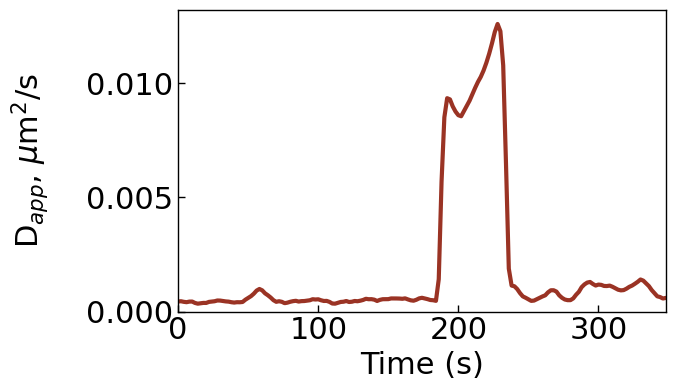

In [14]:
# Plot diffusion coefficient (D_app)
plt.figure(figsize=(7, 4))
plt.plot(arr_t_start, arr_log10D, lw=3, c="#9a3324")
plt.xlabel("Time (s)", fontsize=22)
plt.ylabel(r"D$_{app}$, $\mu$m$^2$/s", fontsize=22)
plt.ylim(0, None)
plt.gca().yaxis.set_label_coords(-0.26, 0.5)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(axis="both", which="major", labelsize=22, direction="in", bottom=True, left=True, length=5, width=1)
plt.xlim(arr_t_start[0], arr_t_start[-1])
plt.tight_layout()
plt.show()


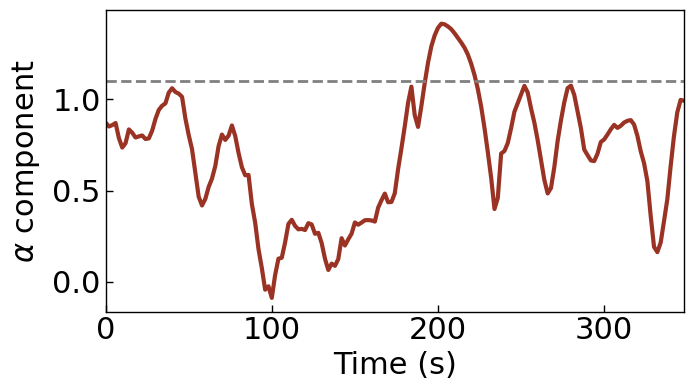

In [15]:
# Plot alpha component (normal)
plt.figure(figsize=(7, 4))
plt.plot(arr_t_start, arr_alpha, lw=3, c="#9a3324")
plt.axhline(1.1, ls="--", c="gray", lw=2)
plt.xlabel("Time (s)", fontsize=22)
plt.ylabel(r"$\alpha$ component", fontsize=22)
plt.gca().yaxis.set_label_coords(-0.11, 0.5)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(axis="both", which="major", labelsize=22, direction="in", bottom=True, left=True, length=5, width=1)
plt.xlim(arr_t_start[0], arr_t_start[-1])
plt.tight_layout()
plt.show()

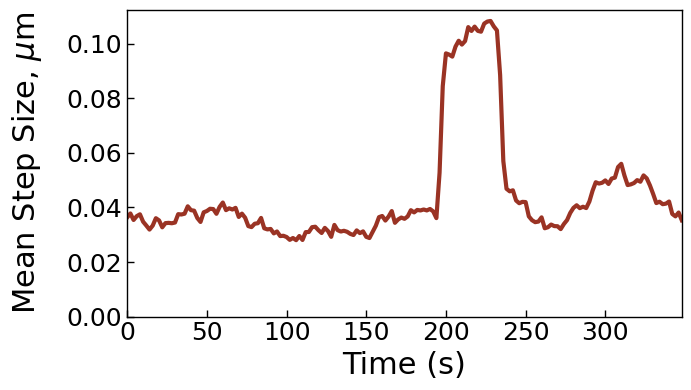

In [16]:
# Plot step size (mean step sizes)
plt.figure(figsize=(7, 4))
plt.plot(arr_t_start, arr_step_size, lw=3, c="#9a3324")
# plt.axhline(0.117, ls="--", c="gray", lw=2)
plt.xlabel("Time (s)", fontsize=22)
plt.ylabel(r"Mean Step Size, $\mu$m", fontsize=22)
plt.ylim(0, None)
plt.gca().yaxis.set_label_coords(-0.15, 0.5)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(axis="both", which="major", labelsize=fontsize, direction="in", bottom=True, left=True, length=5, width=1)
plt.xlim(arr_t_start[0], arr_t_start[-1])
plt.tight_layout()
plt.show()